In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import warnings
import sys
import subprocess
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
ds = load_dataset("wangrongsheng/ag_news")


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# def start_gemma2_session():
#     """
#     Start Gemma2 through Ollama and return the process instance.

#     Returns:
#         subprocess.Popen: Persistent Gemma2 process.
#     """
#     gemma2_process = subprocess.Popen(
#         ["ollama", "run", "gemma2"],
#         stdin=subprocess.PIPE,
#         stdout=subprocess.PIPE,
#         stderr=subprocess.PIPE,
#         text=True
#     )
#     return gemma2_process


In [ ]:
# def interact_with_gemma2(gemma2_process, prompt):
#     """
#     Send a prompt to Gemma2 and retrieve its response.

#     Args:
#         gemma2_process (subprocess.Popen): The running Gemma2 process.
#         prompt (str): The prompt to send.

#     Returns:
#         str: The response from Gemma2.
#     """
#     # Write the prompt to Gemma2
#     gemma2_process.stdin.write(prompt + "\n")
#     gemma2_process.stdin.flush()

#     # Read the response
#     response = gemma2_process.stdout.readline().strip()
#     return response



In [3]:
classifier = pipeline('zero-shot-classification', model=model_name, device=1)                              
sequence_to_classify = "This is a test"
candidate_labels = ['travel', 'cooking', 'dancing', 'technician', 'teacher']
classifier(sequence_to_classify, candidate_labels)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'This is a test',
 'labels': ['technician', 'travel', 'teacher', 'dancing', 'cooking'],
 'scores': [0.4375876188278198,
  0.17017927765846252,
  0.16035453975200653,
  0.13061025738716125,
  0.10126830637454987]}

In [4]:
def perform_error_analysis(dataset, classifier, label_map, num_samples=100):
    """
    Perform comprehensive error analysis on the zero-shot classifier.
    Returns the analysis results as a string and the results DataFrame.
    
    Args:
        dataset: The AG News dataset
        classifier: The zero-shot classification pipeline
        label_map: Dictionary mapping label indices to descriptions
        num_samples: Number of samples to analyze (use smaller number for testing)
    """
    output_string = ""
    
    # Prepare candidate labels for zero-shot classification
    candidate_labels = list(label_map.values())
    output_string += f"Candidate labels: {candidate_labels}\n\n"
    
    # Store results
    results = []
    
    # Process test samples
    for i, item in tqdm(enumerate(dataset['test']), total=num_samples):
        if i >= num_samples:
            break
            
        text = item['text']
        true_label = label_map[item['label']]
        
        # Get model prediction
        prediction = classifier(text, candidate_labels)
        predicted_label = prediction['labels'][0]
        confidence = prediction['scores'][0]
        
        results.append({
            'text': text,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': true_label == predicted_label
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    accuracy = (df_results['correct'].sum() / len(df_results)) * 100
    output_string += f"Overall Accuracy: {accuracy:.2f}%\n\n"
    
    # 2. Per-class Performance
    output_string += "Per-class Performance:\n"
    class_report = classification_report(df_results['true_label'], df_results['predicted_label'])
    output_string += f"{class_report}\n"
    
    # 5. Error Examples Analysis
    output_string += "Most Confident Mistakes:\n"
    mistakes = df_results[~df_results['correct']].sort_values('confidence', ascending=False)
    mistake_df = mistakes[['text', 'true_label', 'predicted_label', 'confidence']].head()
    output_string += mistake_df.to_string()
    output_string += "\n"

    return df_results, output_string, accuracy

In [5]:
from collections import defaultdict

def analyze_error_patterns(df_results):
    """
    Analyze specific patterns in the errors and return them as a string.
    """
    # Common misclassification patterns
    error_patterns = defaultdict(int)
    for _, row in df_results[~df_results['correct']].iterrows():
        pattern = f"{row['true_label']} → {row['predicted_label']}"
        error_patterns[pattern] += 1

    # Collect the output lines in a list
    output_lines = ["\nCommon Error Patterns:"]
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        output_lines.append(f"{pattern}: {count}")

    # Join the lines into a single string and return
    # print("\n".join(output_lines))
    return "\n".join(output_lines)

        
    # # Confidence threshold analysis
    # thresholds = np.arange(0.1, 1.0, 0.1)
    # accuracies = []
    # coverage = []
    
    # for threshold in thresholds:
    #     filtered_preds = df_results[df_results['confidence'] >= threshold]
    #     if len(filtered_preds) > 0:
    #         acc = (filtered_preds['correct'].sum() / len(filtered_preds)) * 100
    #         cov = (len(filtered_preds) / len(df_results)) * 100
    #         accuracies.append(acc)
    #         coverage.append(cov)
    
    # # Ensure arrays are the same length before plotting
    # min_len = min(len(accuracies), len(coverage))
    # thresholds = thresholds[:min_len]
    # accuracies = accuracies[:min_len]
    # coverage = coverage[:min_len]
    
    # if min_len > 0:  # Only plot if we have data
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
    #     plt.plot(thresholds, coverage, 'r-', label='Coverage')
    #     plt.xlabel('Confidence Threshold')
    #     plt.ylabel('Percentage')
    #     plt.title('Accuracy vs Coverage Trade-off')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()
    # else:
    #     print("Warning: Not enough data points to create accuracy-coverage plot")


STOP

In [ ]:
# # Example usage
# if __name__ == "__main__":
#     # Initialize Gemma2 session
#     gemma2 = start_gemma2_session()

#     # Initial prompt
#     initial_prompt = "You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset. I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts then iteratively I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task, I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts. Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" (without the \ because that's only for passing double string to you in python) where the values of the dictionary correspond to the prompts that you generate. Do not generate any text other than these prompts in dictionary format. If after 2-3 iterations the accuracy doesn't increase by much than try different methods. Also if you are able to achieve precision of over 90 for any of the four labels then don't change the prompt for those by much."
#     current_prompt = initial_prompt

#     # Iteratively refine the prompt using Gemma2
#     iterations = 3
#     for i in range(iterations):
#         print(f"Iteration {i + 1}: Current Prompt -> {current_prompt}")
#         refined_prompt = interact_with_gemma2(gemma2, current_prompt)
#         print(f"Refined Prompt -> {refined_prompt}")
#         current_prompt = refined_prompt

#         # Use the refined prompt for classification
#         print("\nUsing the final refined prompt for analysis...")
#         candidate_labels = [f"{refined_prompt} ({label})" for label in ["politics", "sports", "economics", "science and technology"]]

#         # Perform main error analysis with the refined prompt
#         results_df = perform_error_analysis(ds, classifier, num_samples=500, prompt=refined_prompt)
        
#         # Analyze error patterns
#         analyze_error_patterns(results_df)

#     # Terminate Gemma2 session
#     gemma2.terminate()

In [ ]:
# from ollama import chat

# models = ['nemotron']

message = '''You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset.  
I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts). 
The AG News dataset provides us with the following intial labels: 0: World, 1: Sports, 2: Business, 4: Sci/Tech
Then iteratively, I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task.
I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts.
I will also give you the per class accuracy, the most confident mistakes, and common error patterns observed for the given labels. Infer whatever you want to from them and try to make your results better.(Follow the format exactly, dont miss any commas or inverted commas)
Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" where the values of the dictionary correspond to the prompts that you generate. (The prompts aren't questions, they are assertions)
Do not generate any text other than these prompts in dictionary format. 
Also if you are able to achieve precision of over 0.90 for any of the four labels then don't change the prompt for those at all.
This is my initial input to you, from the next message onwards, I will start giving the above mentioned data as the message, I won't provide any other information in the subsequent messages, so use the information I gave in this message to interpret the data provided.
Also, don't give any non alphanumeric characters in the output such as emojis or emoticons. 
Overall Accuracy: 48.50%

Per-class Performance:
              precision    recall  f1-score   support

    Business       0.36      0.08      0.13       205
    Sci/Tech       0.91      0.21      0.34       253
      Sports       0.75      0.68      0.72       274
       World       0.35      0.85      0.50       268

    accuracy                           0.48      1000
   macro avg       0.60      0.46      0.42      1000
weighted avg       0.61      0.48      0.44      1000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                    text  \
702                                                                                                                                  HP Unveils Cavalcade of Consumer Products (PC World) PC World - First TVs, new printers, long-lasting inks, and projectors are targeted\ at living room and office.   
624  World #39;s smallest digital camera with zoom lens Come September, Japanese electronics giant Casio Computer will launch the world #39;s smallest digital camera with a zoom lens. Casio #39;s palm-sized Exilim camera is much smaller than others as, for the first time, it uses a ceramic lens.   
468                                                                                              Microsoft: Use Script to Block Windows XP SP2 Updates Microsoft has offered up yet another way for businesses to block the automatic update of Windows XP to the big-deal Service Pack 2 (SP2) upgrade.   
821                                                                                                  We owe Athens an apology ATHENS -- The Games of the XXVIII Olympiad -- the great disaster that wasn #39;t -- come to an emotional end this afternoon and, really, the world owes Athens an apology.   
963                                       EU, Japan Win WTO Approval to Impose Duties on US (Update2) The European Union, Japan and Brazil won World Trade Organization backing to impose tariffs on US imports after Congress failed to end illegal corporate subsidies worth \$850 million since 2001.   

    true_label predicted_label  confidence  
702   Sci/Tech           World    0.952798  
624   Sci/Tech           World    0.937181  
468   Sci/Tech        Business    0.881427  
821     Sports           World    0.867683  
963   Business           World    0.826846  


Common Error Patterns:
Business → World: 173
Sci/Tech → World: 160
Sports → World: 87
World → Sports: 36
Sci/Tech → Business: 28
Business → Sports: 14
Sci/Tech → Sports: 12
World → Sci/Tech: 3
Business → Sci/Tech: 2

(print only in the format described and print nothing else, don't forget the double quotations for the prompts)
    Output format: {0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}

'''

# for i in models:
#   print("Model name:", i)
#   stream = chat(
#       model=i,
#       messages=[{'role': 'user', 'content': message}],
#       stream=True,
#   )
  
#   for chunk in stream:
#     print(chunk['message']['content'], end='', flush=True)
#   print()

In [24]:
from ollama import chat
import ast
import matplotlib.pyplot as plt

MAX_ITERATIONS = 20

# Initialize model and variables
model_name = 'nemotron'

# Initial label map
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 4: 'Sci/Tech'}
best_accuracy = 48.5
accuracy_data = [48.5]
iteration_data = list(range(1, MAX_ITERATIONS + 1))

initial_interaction = True
# Function to interact with the LLM
def interact_with_llm(model_name, prompt):
    
    stream = chat(
        model=model_name,
        messages=[{'role': 'user', 'content': prompt}],
        stream=True,
    )
    response = ""
    for chunk in stream:
        response += chunk['message']['content']
    new_labels=response.strip()
    print(new_labels)
    dictionary = ast.literal_eval(new_labels)
    return dictionary

# Loop for iterative prompt refinement
iteration = 1
response = ""
while iteration <= MAX_ITERATIONS:
    print(f"\nIteration {iteration}: Current label prompts:")
    for k, v in label_map.items():
        print(f"{k}: \"{v}\"") 
    if(initial_interaction):
        label_map = interact_with_llm(model_name, message)
        initial_interaction = False
    
    else:

        

        # Get outputs from func1 and func2
        results_df, output1, accuracy = perform_error_analysis(ds, classifier, label_map, num_samples=3000)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        output2 = analyze_error_patterns(results_df)
        accuracy_data.append(accuracy)

        # print(f"func1 output: {output1}")
        # print(f"func2 output: {output2}")
        
        # Prepare input message for the LLM
        llm_input = f"""
            Here are the current prompts for labels:\n{label_map}
            Here is the analysis for your last set of prompts/labels for the data:
            {output1}
            {output2}
            
            The original labels provided by AG News were: 0: World, 1: Sports, 2: Business, 4: Sci/Tech
            
            Using this and the current prompts, generate improved prompts for the labels.(print only in the format described and print nothing else, also the prompts should not be questions, rather they should be assertions, foreg. try to start your prompt/label with "This text is about.." or something like that) If you are able to achieve f1-score of over 0.90 for any of the four labels then don't change the prompt for those at all, unless all 4 have precision of greater than 0.90, then you can try to improve the parts a little bit. respond with the exact output format and nothing else.
            Output format: {{0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}}
            Remember to output in this format only and not put anything else as I will be feeding this into Python directly as a dictionary.[STRICT]
            """
    
        print(llm_input)

        # Send current prompts and function outputs to the LLM
        label_map = interact_with_llm(model_name, llm_input)

        

    iteration += 1


plt.figure(figsize=(8, 6))
plt.plot(iteration_data, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)

plt.show()







Iteration 1: Current label prompts:
0: "World"
1: "Sports"
2: "Business"
4: "Sci/Tech"
{0: "This text is about global news and events", 
1: "The subject matter of this article is related to sports news and updates", 
2: "This piece of writing focuses on corporate, financial, or economic news", 
3: "The content of this text revolves around scientific discoveries, emerging tech, or innovative products"}

Iteration 2: Current label prompts:
0: "This text is about global news and events"
1: "The subject matter of this article is related to sports news and updates"
2: "This piece of writing focuses on corporate, financial, or economic news"
3: "The content of this text revolves around scientific discoveries, emerging tech, or innovative products"


  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global news and events', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This piece of writing focuses on corporate, financial, or economic news', 3: 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global news and events', 'The subject matter of this article is related to sports news and updates', 'This piece of writing focuses on corporate, financial, or economic news', 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products']

Overall Accuracy: 74.83%

Per-class Performance:
                                                                                                        precision    recall  f1-score   support

The content of this 

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily covers worldwide events, politics, and social issues', 1: 'The subject matter of this article is related to sports news and updates', 2: 'Financial markets, corporate developments, and economic trends are the main focus of this writing', 3: 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily covers worldwide events, politics, and social issues', 'The subject matter of this article is related to sports news and updates', 'Financial markets, corporate developments, and economic trends are the main focus of this writing', 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products']

Overall Accuracy: 69.53%

Per-class Performance:
                                                   

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global news, political developments, and social issues affecting the world', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on corporate news, economic analysis, market trends, and business developments', 3: 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global news, political developments, and social issues affecting the world', 'The subject matter of this article is related to sports news and updates', 'This writing focuses on corporate news, economic analysis, market trends, and business developments', 'The content of this text revolves around scientific discoveries, emerging tech, or innovative products']

Overall Accuracy: 73.90%

Per-class Performance:
     

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global news, political developments, and social issues affecting the world', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on company operations, financial markets, industry trends, and entrepreneurial ventures', 3: 'This content explores breakthroughs in science, emerging technologies, innovative gadgets, or technological advancements'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global news, political developments, and social issues affecting the world', 'The subject matter of this article is related to sports news and updates', 'This writing focuses on company operations, financial markets, industry trends, and entrepreneurial ventures', 'This content explores breakthroughs in science, emerging technologies, innovative gadgets, or technological advancements']



  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily covers global events, geopolitical developments, social movements, and issues impacting worldwide societies', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing delves into corporate strategies, market analysis, industry shifts, startup ecosystems, and entrepreneurial endeavors', 3: 'This content explores breakthroughs in science, emerging technologies, innovative gadgets, or technological advancements'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily covers global events, geopolitical developments, social movements, and issues impacting worldwide societies', 'The subject matter of this article is related to sports news and updates', 'This writing delves into corporate strategies, market analysis, industry shifts, startup ecosystems, and entrepreneurial endeavors', 'This content

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global events, geopolitics, social issues, and worldwide societal impacts, excluding business and technological developments', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on company operations, market trends, industry innovations, startup environments, and entrepreneurial ventures, with an emphasis on financial and management aspects', 3: 'This content explores breakthroughs in science, emerging technologies, innovative gadgets, or technological advancements'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events, geopolitics, social issues, and worldwide societal impacts, excluding business and technological developments', 'The subject matter of this article is related to sports news and updates', 'This writing focuses on company operations, market trends, 

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about significant global events, geopolitics, social issues, and their impacts on society, excluding corporate and technological topics', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on company operations, market trends, industry innovations, startup environments, and entrepreneurial ventures, with an emphasis on financial and management aspects', 3: 'This content delves into scientific discoveries, emerging tech trends, innovative product releases, and technological advancements shaping various industries'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about significant global events, geopolitics, social issues, and their impacts on society, excluding corporate and technological topics', 'The subject matter of this article is related to sports news and updates', 'This writing

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily discusses global news, geopolitical developments, social movements, and their societal implications without focusing on corporate or technological aspects', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing centers around business operations, market analysis, industry shifts, entrepreneurial endeavors, and financial management strategies with minimal emphasis on technology', 3: 'This content explores cutting-edge scientific research, emerging technologies, innovative product launches, and tech-driven advancements across various sectors'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily discusses global news, geopolitical developments, social movements, and their societal implications without focusing on corporate or technological aspects', 'The subject matter of this article is 

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global news, geopolitical developments, social issues, and their broader societal impacts, excluding corporate and technological themes', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on financial markets, entrepreneurial ventures, industry trends, and management strategies with limited reference to technology and scientific innovation', 3: 'This content explores cutting-edge scientific research, emerging technologies, innovative product launches, and tech-driven advancements across various sectors'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global news, geopolitical developments, social issues, and their broader societal impacts, excluding corporate and technological themes', 'The subject matter of this article is related to sports news and updates', 'This writ

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily covers global events, geopolitical issues, social topics, and their far-reaching societal implications, without focusing on corporate or technological aspects', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing delves into the world of finance, entrepreneurship, industry analysis, and business strategies, often discussing market trends with minimal emphasis on scientific innovations', 3: 'This content explores cutting-edge scientific research, emerging technologies, innovative product launches, and tech-driven advancements across various sectors'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily covers global events, geopolitical issues, social topics, and their far-reaching societal implications, without focusing on corporate or technological aspects', 'The subject matter of th

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global events, geopolitics, social issues, and their broad societal impacts, excluding corporate and technological topics', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing focuses on business, entrepreneurship, industry trends, and financial strategies with little emphasis on scientific innovation or technology', 3: 'This content explores cutting-edge scientific research, emerging technologies, innovative product launches, and tech-driven advancements across various sectors'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events, geopolitics, social issues, and their broad societal impacts, excluding corporate and technological topics', 'The subject matter of this article is related to sports news and updates', 'This writing focuses on business, entrepreneurship, indust

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily discusses global events, geopolitics, social issues, and their broad societal impacts, with minimal focus on corporate, technological, or scientific advancements', 1: 'The subject matter of this article is related to sports news and updates', 2: 'This writing centers around business operations, entrepreneurship, industry trends, financial strategies, and economic news, excluding in-depth scientific innovation or emerging technologies', 3: 'This content explores cutting-edge scientific research, emerging technologies, innovative product launches, and tech-driven advancements across various sectors'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily discusses global events, geopolitics, social issues, and their broad societal impacts, with minimal focus on corporate, technological, or scientific advancements', 'The subject mat

KeyboardInterrupt: 

In [22]:
import re

# Input string (your data)
data = """

Iteration 1: Current label prompts:
0: "World"
1: "Sports"
2: "Business"
4: "Sci/Tech"
{0: "This text is about global events or international news", 
1: "The topic of this article is sports related", 
2: "This piece of writing focuses on corporate or financial news", 
3: "The subject matter of this text involves science, technology, or innovations"}

Iteration 2: Current label prompts:
0: "This text is about global events or international news"
1: "The topic of this article is sports related"
2: "This piece of writing focuses on corporate or financial news"
3: "The subject matter of this text involves science, technology, or innovations"
100%
 3000/3000 [02:07<00:00, 23.65it/s]

            Here are the current prompts for labels:
{0: 'This text is about global events or international news', 1: 'The topic of this article is sports related', 2: 'This piece of writing focuses on corporate or financial news', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events or international news', 'The topic of this article is sports related', 'This piece of writing focuses on corporate or financial news', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 80.70%

Per-class Performance:
                                                                              precision    recall  f1-score   support

The subject matter of this text involves science, technology, or innovations       0.77      0.72      0.75       776
                                 The topic of this article is sports related       0.95      0.97      0.96       775
                This piece of writing focuses on corporate or financial news       0.79      0.68      0.73       702
                      This text is about global events or international news       0.72      0.84      0.78       747

                                                                    accuracy                           0.81      3000
                                                                   macro avg       0.81      0.80      0.80      3000
                                                                weighted avg       0.81      0.81      0.81      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                    text                                                                    true_label                                                               predicted_label  confidence
796                                                                                                      The Hunt for a Hybrid The Aug. 23 front-page article on the Toyota Prius vs. the Honda Civic implied that the main reason people prefer the Prius was its  quot;geek-chic look quot; and the image buyers want.                  This piece of writing focuses on corporate or financial news  The subject matter of this text involves science, technology, or innovations    0.947209
1883  CRM Best Practices: TCO and ROI (NewsFactor) NewsFactor - With CRM projects costing millions, even in some mid-size companies, it is no surprise CFOs are leading the charge to be sure the most important projects are first, that they are justified, and that they actually deliver on their forecast benefits.  The subject matter of this text involves science, technology, or innovations                  This piece of writing focuses on corporate or financial news    0.932422
1140                        Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.  The subject matter of this text involves science, technology, or innovations                                   The topic of this article is sports related    0.929484
...
0: "This text is about geopolitics, global issues, or international relations"
1: "The topic of this article is sports related"
2: "This piece of writing primarily discusses company operations, financial markets, or economic trends"
3: "The subject matter of this text involves science, technology, or innovations"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [04:33<00:00, 10.54it/s]

            Here are the current prompts for labels:
{0: 'This text is about geopolitics, global issues, or international relations', 1: 'The topic of this article is sports related', 2: 'This piece of writing primarily discusses company operations, financial markets, or economic trends', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about geopolitics, global issues, or international relations', 'The topic of this article is sports related', 'This piece of writing primarily discusses company operations, financial markets, or economic trends', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 72.13%

Per-class Performance:
                                                                                                     precision    recall  f1-score   support

                       The subject matter of this text involves science, technology, or innovations       0.70      0.85      0.77       776
                                                        The topic of this article is sports related       0.94      0.99      0.96       775
This piece of writing primarily discusses company operations, financial markets, or economic trends       0.84      0.13      0.22       702
                          This text is about geopolitics, global issues, or international relations       0.57      0.87      0.69       747

                                                                                           accuracy                           0.72      3000
                                                                                          macro avg       0.76      0.71      0.66      3000
                                                                                       weighted avg       0.76      0.72      0.67      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                              text                                                                                           true_label                                                               predicted_label  confidence
1140  Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.                         The subject matter of this text involves science, technology, or innovations                                   The topic of this article is sports related    0.959912
796                                                                                The Hunt for a Hybrid The Aug. 23 front-page article on the Toyota Prius vs. the Honda Civic implied that the main reason people prefer the Prius was its  quot;geek-chic look quot; and the image buyers want.  This piece of writing primarily discusses company operations, financial markets, or economic trends  The subject matter of this text involves science, technology, or innovations    0.953717
806                                           Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.  This piece of writing primarily discusses company operations, financial markets, or economic trends  The subject matter of this text involves science, technology, or innovations    0.945664
...
0: "This text is about global events, international conflicts, or geopolitical dynamics"
1: "The topic of this article is sports related"
2: "This piece of writing focuses on corporate news, market analysis, or financial industry trends"
3: "The subject matter of this text involves science, technology, or innovations"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [03:04<00:00, 10.88it/s]

            Here are the current prompts for labels:
{0: 'This text is about global events, international conflicts, or geopolitical dynamics', 1: 'The topic of this article is sports related', 2: 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events, international conflicts, or geopolitical dynamics', 'The topic of this article is sports related', 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 82.13%

Per-class Performance:
                                                                                                precision    recall  f1-score   support

                  The subject matter of this text involves science, technology, or innovations       0.78      0.78      0.78       776
                                                   The topic of this article is sports related       0.94      0.98      0.96       775
This piece of writing focuses on corporate news, market analysis, or financial industry trends       0.79      0.66      0.72       702
           This text is about global events, international conflicts, or geopolitical dynamics       0.76      0.85      0.80       747

                                                                                      accuracy                           0.82      3000
                                                                                     macro avg       0.82      0.82      0.82      3000
                                                                                  weighted avg       0.82      0.82      0.82      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                    text                                                                                      true_label                                                                                 predicted_label  confidence
1140                        Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.                    The subject matter of this text involves science, technology, or innovations                                                     The topic of this article is sports related    0.957637
806                                                                 Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.  This piece of writing focuses on corporate news, market analysis, or financial industry trends                    The subject matter of this text involves science, technology, or innovations    0.932307
796                                                                                                      The Hunt for a Hybrid The Aug. 23 front-page article on the Toyota Prius vs. the Honda Civic implied that the main reason people prefer the Prius was its  quot;geek-chic look quot; and the image buyers want.  This piece of writing focuses on corporate news, market analysis, or financial industry trends                    The subject matter of this text involves science, technology, or innovations    0.930938
...
0: "This text is about global events, international conflicts, or geopolitical dynamics"
1: "The topic of this article is sports related"
2: "This content focuses on company operations, market trends, financial reports, or industry analysis"
3: "This text is about scientific discoveries, emerging technologies, or innovative developments"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
 86%
 2588/3000 [02:09<00:18, 22.08it/s]

            Here are the current prompts for labels:
{0: 'This text is about global events, international conflicts, or geopolitical dynamics', 1: 'The topic of this article is sports related', 2: 'This content focuses on company operations, market trends, financial reports, or industry analysis', 3: 'This text is about scientific discoveries, emerging technologies, or innovative developments'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events, international conflicts, or geopolitical dynamics', 'The topic of this article is sports related', 'This content focuses on company operations, market trends, financial reports, or industry analysis', 'This text is about scientific discoveries, emerging technologies, or innovative developments']

Overall Accuracy: 73.07%

Per-class Performance:
                                                                                                    precision    recall  f1-score   support

                                                       The topic of this article is sports related       0.94      0.98      0.96       775
This content focuses on company operations, market trends, financial reports, or industry analysis       0.57      0.74      0.64       702
               This text is about global events, international conflicts, or geopolitical dynamics       0.66      0.85      0.74       747
      This text is about scientific discoveries, emerging technologies, or innovative developments       0.86      0.36      0.50       776

                                                                                          accuracy                           0.73      3000
                                                                                         macro avg       0.76      0.73      0.71      3000
                                                                                      weighted avg       0.76      0.73      0.71      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                    text                                                                                          true_label                                                                                     predicted_label  confidence
1140                        Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.        This text is about scientific discoveries, emerging technologies, or innovative developments                                                         The topic of this article is sports related    0.945263
2006                                                                                                   Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.        This text is about scientific discoveries, emerging technologies, or innovative developments  This content focuses on company operations, market trends, financial reports, or industry analysis    0.925501
1883  CRM Best Practices: TCO and ROI (NewsFactor) NewsFactor - With CRM projects costing millions, even in some mid-size companies, it is no surprise CFOs are leading the charge to be sure the most important projects are first, that they are justified, and that they actually deliver on their forecast benefits.        This text is about scientific discoveries, emerging technologies, or innovative developments  This content focuses on company operations, market trends, financial reports, or industry analysis    0.864513
...
0: "This text primarily discusses international relations, geopolitical conflicts, or worldwide news events"
1: "The topic of this article is sports related"
2: "This content focuses on corporate news, financial market analysis, or industry-specific business developments"
3: "This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:33<00:00, 26.74it/s]

            Here are the current prompts for labels:
{0: 'This text primarily discusses international relations, geopolitical conflicts, or worldwide news events', 1: 'The topic of this article is sports related', 2: 'This content focuses on corporate news, financial market analysis, or industry-specific business developments', 3: 'This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily discusses international relations, geopolitical conflicts, or worldwide news events', 'The topic of this article is sports related', 'This content focuses on corporate news, financial market analysis, or industry-specific business developments', 'This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development']

Overall Accuracy: 65.93%

Per-class Performance:
                                                                                                                  precision    recall  f1-score   support

                                                                     The topic of this article is sports related       0.94      0.98      0.96       775
   This content focuses on corporate news, financial market analysis, or industry-specific business developments       0.62      0.89      0.73       702
This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development       0.46      0.64      0.53       776
         This text primarily discusses international relations, geopolitical conflicts, or worldwide news events       0.94      0.13      0.23       747

                                                                                                        accuracy                           0.66      3000
                                                                                                       macro avg       0.74      0.66      0.61      3000
                                                                                                    weighted avg       0.74      0.66      0.61      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                             text                                                                                                        true_label                                                                                                   predicted_label  confidence
2006                                                                                                                                                                            Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.  This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development     This content focuses on corporate news, financial market analysis, or industry-specific business developments    0.918572
806                                                                                                                                          Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.     This content focuses on corporate news, financial market analysis, or industry-specific business developments  This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development    0.911020
1883                                                                           CRM Best Practices: TCO and ROI (NewsFactor) NewsFactor - With CRM projects costing millions, even in some mid-size companies, it is no surprise CFOs are leading the charge to be sure the most important projects are first, that they are justified, and that they actually deliver on their forecast benefits.  This text explores breakthroughs in science, emerging tech innovations, or cutting-edge research and development     This content focuses on corporate news, financial market analysis, or industry-specific business developments    0.902679
...
{0: "This text is about global events, geopolitics, or international news beyond a country's domestic affairs",
1: "The topic of this article is sports related" (No change, precision > 0.90),
2: "This content revolves around company operations, financial markets, industry trends, or economic developments",
3: "This text delves into scientific discoveries, emerging technologies, innovative research, or technological advancements"}
"""

# Regex pattern to find all instances of "Overall Accuracy:" followed by a number
pattern = r"Overall Accuracy:\s*([\d.]+)%"

# Find all matches
accuracies = re.findall(pattern, data)


# Convert to a list of floats
accuracy_list = [float(acc) for acc in accuracies]
accuracy_list.insert(0, 48.50)
# Print the result

print(accuracy_list)


[48.5, 80.7, 72.13, 82.13, 73.07, 65.93]


Best Accuracy:  82.13333333333334


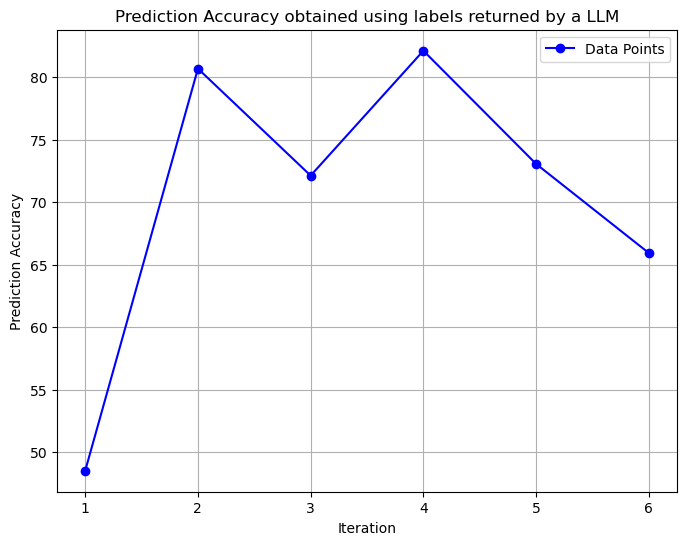

In [ ]:
iterations_list1 = [i for i in range(1,7)]

plt.figure(figsize=(8, 6))
plt.plot(iterations_list1, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)



print("Best Accuracy: " , best_accuracy)
plt.savefig('nemotron_accuracy_2.png', dpi = 300, bbox_inches = 'tight')
plt.show()
